Importing necesseary libraries like ndjson numpy torch etc.

In [152]:
# Import neceserray libraries
import json
import ndjson
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
from collections import defaultdict
from typing import List

In [4]:
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"🔧 CUDA available: {torch.cuda.is_available()}")

🔧 PyTorch version: 2.7.1+cu126
🔧 CUDA available: False


In [ ]:
# Deterministic seeding for ensure same randomizing 
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [ ]:
# A helper function to open indices jsons
def load_json_indices(category: str):
    path = f"./subset/{category}/indices.json"
    file_path = Path(path)
    
    if not file_path.exists():
        print(f"Data file not found category maybe wrong: {category}")
        return None
    
    with open(file_path, 'r') as f:
        indices = json.load(f)
    
    train_indices = indices['train']
    test_indices = indices['test']
    
    print(f"{category.upper()} - Train: {len(train_indices)}, Test: {len(test_indices)}")
    return train_indices, test_indices
    

In [ ]:
bus_train_data, bus_test_data = load_json_indices("bus")

BUS - Train: 10000, Test: 2000


In [ ]:
# A helper function to open skethes as ndjsons
def load_sketches(category: str):
    path = f"./data/{category}.ndjson"
    file_path = Path(path)
    
    if not file_path.exists():
        print(f"Data file not found ndjson category maybe wrong: {category}")
        return None
    
    sketches = []
    with open(file_path, 'r') as f:
        for line_num, line in enumerate(f):
            try:
                sketch = json.loads(line.strip())
                sketches.append(sketch)
                
            except json.JSONDecodeError as e:
                print(f"JSON decode error at line {line_num}: {e}")
                continue
    
    print(f"Loaded {len(sketches)} sketches for {category}")
    return sketches

In [ ]:
bus_sketches = load_sketches("bus")

Loaded 166208 sketches for bus


In [69]:
# Filter drawings according to category indices
def filter_drawings(sketches, train_indices, test_indices):
    total_drawings = len(sketches)
    
    print(f"Total drawings available: {total_drawings}")
    print(f"Train indices requested: {len(train_indices)}")
    print(f"Test indices requested: {len(test_indices)}")
    
    # Extract actual drawings using valid indices
    train_drawings = []
    test_drawings = []
    
    for idx in train_indices:
        train_drawings.append(sketches[idx])
    
    for idx in test_indices:
        test_drawings.append(sketches[idx])
        
    print(f"Train samples: {len(train_drawings)}")
    print(f"Test samples: {len(test_drawings)}")
    
    return train_drawings, test_drawings

In [79]:
bus_train_drawings, bus_test_drawings = filter_drawings(bus_sketches, bus_train_data, bus_test_data)

Total drawings available: 166208
Train indices requested: 10000
Test indices requested: 2000
Train samples: 10000
Test samples: 2000


In [80]:
# Label stroke squences and format them as (X, Y, SEQ) 
def label_stroke_seq(sketches):
    sequences = []
    sequence_lengths = []
    stroke_counts = []
    
    # Iterating over drawings 
    for sketche_idx, sketche_data in enumerate(sketches):
        if 'drawing' not in sketche_data:
            continue
        
        sketch = sketche_data['drawing'] # Getting drawing vectors
        sequence = [] # List for stroke sequence label
        
        # Process strokes
        for stroke_idx, stroke in enumerate(sketch):
            if len(stroke) < 2:  # Skip invalid strokes
                continue
                
            x_coords = stroke[0]
            y_coords = stroke[1]
            
            for point_idx, (x, y) in enumerate(zip(x_coords, y_coords)):
                if point_idx == 0:
                    pen_state = 1 # start stroke
                else:
                    pen_state = 2 # continue stroke
                
                # Appending sequence x,y coordinate with pen state as squence
                sequence.append([x, y, pen_state])
            
            if stroke_idx < len(sketch) - 1:
                sequence.append([x_coords[-1], y_coords[-1], 0])  # end stroke
            
        if sequence:
            sequence.append([0, 0, 3])  # end of drawing
            sequences.append(sequence)
            sequence_lengths.append(len(sequence))
            stroke_counts.append(len(sketch))
    
    print(f"Processed drawings: {len(sequences)}")
    print(f"Avg sequence length: {np.mean(sequence_lengths):.1f}")
    print(f"Avg stroke count: {np.mean(stroke_counts):.1f}")
    print(f"Max sequence length: {np.max(sequence_lengths)}")
    print(f"Min sequence length: {np.min(sequence_lengths)}")
    
    return sequences, sequence_lengths, stroke_counts

In [82]:
bus_train_sequences, bus_train_sequence_lengths, bust_train_stroke_counts =  label_stroke_seq(bus_train_drawings)
print()
bus_test_sequences, bus_test_sequence_lengths, bust_test_stroke_counts =  label_stroke_seq(bus_test_drawings)

Processed drawings: 10000
Avg sequence length: 67.7
Avg stroke count: 7.3
Max sequence length: 451
Min sequence length: 4

Processed drawings: 2000
Avg sequence length: 66.9
Avg stroke count: 7.3
Max sequence length: 292
Min sequence length: 4


In [91]:
# Normalizing the x,y corrdinates to ensure scaling
def normalize_coordinates(sequences):
    # Establish normalization thresholds
    old_min, old_max = 0, 255
    new_min, new_max = -1, 1
    scale = (new_max - new_min) / (old_max - old_min)
    
    normalized_sequences = []
    
    for seq in sequences:
        normalized_sequence = []
        for point in seq:
            x, y, pen_state = point
            
            # Normalize coordinates
            norm_x = new_min + (x - old_min) * scale
            norm_y = new_min + (y - old_min) * scale
            
            # Add normalized points to the sequence list
            normalized_sequence.append([norm_x, norm_y, pen_state])

        # Add normalized sequene to sequences list
        normalized_sequences.append(normalized_sequence)
        
    print(f"Sequences normalized: {len(normalized_sequences)}")
    
    return normalized_sequences
    

In [101]:
bus_test_sequences[0][0]

[0, 4, 1]

In [98]:
normalized_bus_train_sequences = normalize_coordinates(bus_train_sequences)
print()
normalized_bus_test_sequences = normalize_coordinates(bus_test_sequences)

Sequences normalized: 10000

Sequences normalized: 2000


In [ ]:
# Calculate the max length for padding operations 
def calculate_max_length(train_sequences, test_sequences):
    # Get all sequence lengths
    train_lengths = [len(seq) for seq in train_sequences]
    test_lengths = [len(seq) for seq in test_sequences]
    all_lengths = train_lengths + test_lengths
    
    # Return maximum length
    max_length = max(all_lengths)
    
    print(f"Max sequence length: {max_length} (train_max: {max(train_lengths)}, test_max: {max(test_lengths)})")
    
    return max_length

In [ ]:
max_length = calculate_max_length(normalized_bus_train_sequences, normalized_bus_test_sequences)

Max sequence length: 451 (train_max: 451, test_max: 292)


In [124]:
# Padding the sequences to ensure every sequence is same length
def pad_sequences(sequences, max_length, pad_value = [0, 0, -1]):
    padded_sequences = []
    actual_lengths = []
    
    for sequence in sequences:
        seq_len = len(sequence)
        actual_lengths.append(min(seq_len, max_length))
        
        if seq_len >= max_length:
            # Truncate long sequences
            padded_seq = sequence[:max_length]
        else:
            # Pad short sequences
            padded_seq = sequence + [pad_value] * (max_length - seq_len)
        
        padded_sequences.append(padded_seq)
        
    print(f"Final sequence length: {max_length}")
    print(f"Padded sequences: {len(padded_sequences)}")
    
    return padded_sequences, actual_lengths

In [125]:
bus_train_padded_sequences, bus_train_data_actual_lengths = pad_sequences(normalized_bus_train_sequences, max_length)
print()
bus_test_padded_sequences, bus_test_data_actual_lengths = pad_sequences(normalized_bus_test_sequences, max_length)

Final sequence length: 451
Padded sequences: 10000

Final sequence length: 451
Padded sequences: 2000


In [137]:
bus_train_data_processed = np.array(bus_train_padded_sequences, dtype=np.float32)
bus_test_data_processed = np.array(bus_test_padded_sequences, dtype=np.float32)
bus_train_data_actual_array = np.array(bus_train_data_actual_lengths, dtype=np.int32)
bus_test_data_actual_array = np.array(bus_test_data_actual_lengths, dtype=np.int32)

In [138]:
dataset = {
    'train_data': bus_train_data_processed,
    'test_data': bus_test_data_processed,
    'train_lengths': bus_train_data_actual_array,
    'test_lengths': bus_test_data_actual_array,
    'max_sequence_length': max_length,
    'category': "bus",
    'train_size': len(bus_train_data_processed),
    'test_size': len(bus_test_data_processed)
}

In [144]:
# Creating a full traning process funtion to streamline preprocess
def create_traning_dataset(category):
    train_indices, test_indices = load_json_indices(category) # Load indices
    sketches = load_sketches(category) # Load sketches
    train_drawings, test_drawings = filter_drawings(sketches, train_indices, test_indices) # Filter out the drawings according to indices
    
    train_sequences, train_sequence_lengths, train_stroke_counts = label_stroke_seq(train_drawings) # Labeling stroke sequences
    test_sequences, test_sequence_lengths, test_stroke_counts = label_stroke_seq(test_drawings)
    
    train_normalized_sequences = normalize_coordinates(train_sequences) # Normalizing sequence coordinates
    test_normalized_sequences = normalize_coordinates(test_sequences)
    
    max_length = calculate_max_length(train_normalized_sequences, test_normalized_sequences) # Calculating max_lenghts for paddings
    
    train_padded_sequences, train_data_actual_lengths = pad_sequences(train_normalized_sequences, max_length) # Pad normalized sequences 
    test_padded_sequences, test_data_actual_lengths = pad_sequences(test_normalized_sequences, max_length)
    
    train_data_processed = np.array(train_padded_sequences, dtype=np.float32) # Convert to numpy array
    test_data_processed = np.array(test_padded_sequences, dtype=np.float32)
    train_data_actual_array = np.array(train_data_actual_lengths, dtype=np.int32)
    test_data_actual_array = np.array(test_data_actual_lengths, dtype=np.int32)
    
    dataset = {
        'train_data': train_data_processed,
        'test_data': test_data_processed,
        'train_lengths': train_data_actual_array,
        'test_lengths': test_data_actual_array,
        'max_sequence_length': max_length,
        'category': "bus",
        'train_size': len(train_data_processed),
        'test_size': len(test_data_processed)
    }
    
    return dataset 

In [ ]:
# Visualize the processed data
def visualize_data(dataset, category, num_samples=5):
    train_data = dataset['train_data']
    train_lengths = dataset['train_lengths']
    
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 5))
    if num_samples == 1:
        axes = [axes]
    
    for i in range(num_samples):
        ax = axes[i]
        
        # Get sequence and actual length
        sequence = train_data[i]
        actual_length = train_lengths[i]
        
        # Extract coordinates (ignore padding)
        coords = sequence[:actual_length]
        
        # Plot drawing
        current_stroke = []
        stroke_num = 0
        colors = plt.cm.Set3(np.linspace(0, 1, 10))
        
        for point in coords:
            x, y, pen_state = point
            
            if pen_state == 1:  # Start stroke
                if current_stroke:  # Plot previous stroke
                    stroke_x, stroke_y = zip(*current_stroke)
                    ax.plot(stroke_x, stroke_y, color=colors[stroke_num % 10], linewidth=2, marker='o', markersize=1)
                    stroke_num += 1
                current_stroke = [(x, y)]
            elif pen_state == 2:  # continue stroke
                current_stroke.append((x, y))
            elif pen_state == 0:  # stop stroke
                if current_stroke:
                    current_stroke.append((x, y))
                    stroke_x, stroke_y = zip(*current_stroke)
                    ax.plot(stroke_x, stroke_y, color=colors[stroke_num % 10], linewidth=2, marker='o', markersize=1)
                    stroke_num += 1
                    current_stroke = []
            elif pen_state == 3:  # end of drowing
                break
        
        # Plot final stroke if exists
        if current_stroke:
            stroke_x, stroke_y = zip(*current_stroke)
            ax.plot(stroke_x, stroke_y, color=colors[stroke_num % 10], linewidth=2, marker='o', markersize=1)
        
        ax.set_title(f'{category.capitalize()} Sample {i+1}\nLength: {actual_length}')
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(-1.2, 1.2) 
        ax.set_ylim(-1.2, 1.2)
        ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

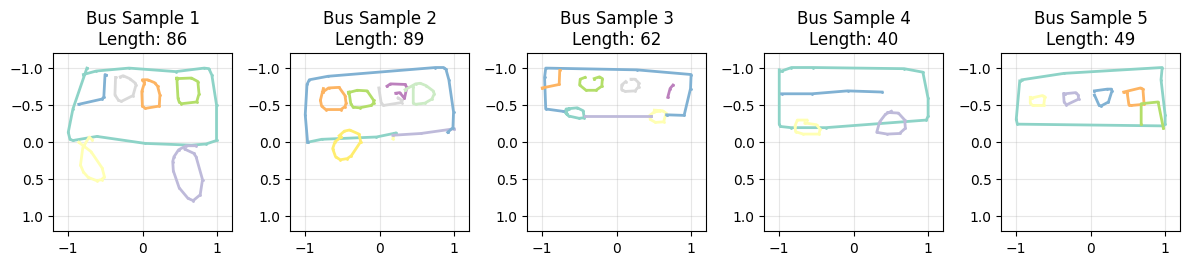

In [149]:
visualize_data(dataset, dataset['category'])

In [154]:
# Complete function to process all categories
def process_categories(categories:List[str]):
    processed_datasets = {}
    
    for category, data in categories.items():
        print(f"PROCESSING CATEGORY: {category.upper()}")
        
        dataset = create_traning_dataset(
            drawings=data['drawings'],
            train_indices=data['train_indices'],
            test_indices=data['test_indices'],
            category=category
        )
        
        processed_datasets[category] = dataset
        
        visualize_data(dataset, category)
        
    for category, dataset in processed_datasets.items():
        print(f"{category.upper()}: {dataset['train_size']} train, {dataset['test_size']} test, seq_len={dataset['max_sequence_length']}")
    
    return processed_datasets